<a href="https://colab.research.google.com/github/neelkanthrawat/GNN-exercises/blob/main/Exercise_3_GNN_for_science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Two moons with an invertible Neural Network

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F

In [2]:
### modified coupling layer class
import torch
import torch.nn as nn
import torch.nn.functional as F

class CouplingLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CouplingLayer, self).__init__()
        # Neural networks for the first half of the dimensions
        self.fc1 = nn.Linear(input_size // 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        # Translation coefficient
        self.fc3 = nn.Linear(hidden_size, input_size // 2)
        # Scaling coefficient
        self.fc4 = nn.Linear(hidden_size, input_size // 2)

    def forward(self, x):
        #print("___ inside the coupling layer's forward function____")
        #print("x is:"); print(x)
        #print("shape of x is:",x.shape)
        # Split the input into two halves
        x_a, x_b = x.chunk(2, dim=1)
        #print("shape x_a is:",x_a.shape)
        #print("shape x_b is:",x_b.shape)

        # Apply neural network to calculate coefficients
        h = F.relu(self.fc1(x_a))
        h = F.relu(self.fc2(h))
        translation = self.fc3(h)
        scaling_before_exp = self.fc4(h)
        scaling = torch.exp(torch.tanh(scaling_before_exp))

        # Apply the affine transformation
        y_b = x_b * scaling + translation

        # Concatenate the transformed halves
        y = torch.cat([x_a, y_b], dim=1)
        #print(" shape of y is (tensor after the coupling layer):");print(y.shape)
        return y, scaling_before_exp

    def backward(self, y):
        # Split the input into two halves
        y_a, y_b = y.chunk(2, dim=1)

        # Apply neural network to calculate coefficients (reverse)
        h = F.relu(self.fc1(y_a))
        h = F.relu(self.fc2(h))
        translation = self.fc3(h)
        scaling_before_exp = self.fc4(h)
        scaling = torch.exp(torch.tanh(scaling_before_exp))

        # Reverse the operations to reconstruct the original input
        x_a = y_a
        x_b = (y_b - translation) / scaling

        # Concatenate the reconstructed halves
        x = torch.cat([x_a, x_b], dim=1)
        return x

In [3]:
class RealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, blocks):
        super(RealNVP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.blocks = blocks

        # List of coupling layers
        self.coupling_layers = nn.ModuleList([
            CouplingLayer(input_size, hidden_size) for _ in range(blocks)
        ])
        #print("self.input size is:",self.input_size)

        # List to store orthonormal matrices
        self.orthonormal_matrices = [self._get_orthonormal_matrix(input_size) for _ in range(blocks)]
        # print("set of orthogonal matrixes are")
        # print(self.orthonormal_matrices)
        # print("some test check: "); print(type(self.orthonormal_matrices[0]))
        # print("shape is:");print(self.orthonormal_matrices)

        # List to store scaling_before_exp for each block
        self.scaling_before_exp_list = []

class RealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, blocks):
        super(RealNVP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.blocks = blocks

        # List of coupling layers
        self.coupling_layers = nn.ModuleList([
            CouplingLayer(input_size, hidden_size) for _ in range(blocks)
        ])
        #print("self.input size is:",self.input_size)


        # List to store orthonormal matrices
        self.orthonormal_matrices = [self._get_orthonormal_matrix(input_size) for _ in range(blocks)]
        # print("set of orthogonal matrixes are")
        # print(self.orthonormal_matrices)
        # print("some test check: "); print(type(self.orthonormal_matrices[0]))
        # print("shape is:");print(self.orthonormal_matrices)

        # List to store scaling_before_exp for each block
        self.scaling_before_exp_list = []

    def _get_orthonormal_matrix(self, size):
        # Function to generate a random orthonormal matrix
        w = torch.randn(size, size)
        q, _ = torch.linalg.qr(w,'reduced')
        return q

    def forward_realnvp(self, x):
        #print("inside the forward_realnvp function")
        scaling_before_exp_list = []
        for i in range(self.blocks):
            # Apply random orthonormal matrix
            #print("type of (self.orthonormal_matrices[0]):",type(self.orthonormal_matrices[0]))
            #print("x is:");print(x)
            #print("self.orthonormal_matrices[i]:");print(self.orthonormal_matrices[i])
            x = torch.matmul(x, self.orthonormal_matrices[i])
            # Apply coupling layer
            x, scaling_before_exp = self.coupling_layers[i](x)
            scaling_before_exp_list.append(scaling_before_exp)

        self.scaling_before_exp_list = scaling_before_exp_list
        return x

    def encode(self, x):
        # Encoding is the forward pass through the RealNVP model
        return self.forward_realnvp(x)

    def decode(self, z):
        # Reverse transformations for decoding
        for i in reversed(range(self.blocks)):
            # Apply random orthonormal matrix (reverse)
            z = z @ self.orthonormal_matrices[i].t()
            # Apply coupling layer (reverse)
            z = self.coupling_layers[i].backward(z)
        return z

    # def forward_realnvp(self, x):
    #     scaling_before_exp_list = []
    #     for i in range(self.blocks):
    #         # Apply random orthonormal matrix
    #         # print("x is:");print(x)
    #         # print("type of (self.orthonormal_matrices[0]):",type(self.orthonormal_matrices[0]))
    #         x = torch.matmul(x[0], self.orthonormal_matrices[i])
    #         # Apply coupling layer
    #         x, scaling_before_exp = self.coupling_layers[i](x)
    #         scaling_before_exp_list.append(scaling_before_exp)

    #     self.scaling_before_exp_list = scaling_before_exp_list
    #     return x

    # def encode(self, x):
    #     # Encoding is the forward pass through the RealNVP model
    #     return self.forward_realnvp(x)

    # def decode(self, z):
    #     # Reverse transformations for decoding
    #     for i in reversed(range(self.blocks)):
    #         # Apply random orthonormal matrix (reverse)
    #         z = z @ self.orthonormal_matrices[i].t()
    #         # Apply coupling layer (reverse)
    #         z = self.coupling_layers[i].backward(z)
    #     return z

In [4]:
### defining our loss function
def calculate_loss(transformed_x, scaling_before_exp_list, dataset_length):
    """
    Calculate the loss for the RealNVP model.

    Args:
    - transformed_x (tensor): Transformed data produced by the RealNVP model.
    - scaling_before_exp_list (list): List of scaling_before_exp values for each block.
    - dataset_length (int): The length of the dataset.

    Returns:
    - loss (tensor): The calculated loss value.
    """

    # Calculate the first term of the loss (negative log-likelihood term)
    first_term = torch.sum(transformed_x**2) / 2

    # Calculate the second term of the loss (sum over scaling_before_exp values)
    second_term = 0.0
    for scaling_before_exp in scaling_before_exp_list:
        second_term -= scaling_before_exp.sum()

    # Calculate the total loss
    loss = (first_term + second_term) / dataset_length

    return loss


In [5]:
import torch.optim as optim

def train_and_evaluate(model, train_loader, val_loader, num_epochs=10, lr=0.001, print_after=1):
    """
    Train the RealNVP model and evaluate on a validation dataset.

    Args:
    - model (RealNVP): The RealNVP model to be trained.
    - train_loader (DataLoader): DataLoader for the training dataset.
    - val_loader (DataLoader): DataLoader for the validation dataset.
    - num_epochs (int): Number of training epochs.
    - lr (float): Learning rate for the optimizer.
    - print_after (int): Number of epochs after which to print the training and validation loss.

    Returns:
    - train_losses (list): List of training losses for each epoch.
    - val_losses (list): List of validation losses for each epoch.
    """

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []  # List to store training losses
    val_losses = []    # List to store validation losses

    for epoch in range(num_epochs):
        total_train_loss = 0.0

        # Training phase
        model.train()  # Set the model to training mode
        for data in train_loader:
            inputs= data

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass (encoding)
            encoded = model.encode(inputs)

            # Loss calculation
            train_loss = calculate_loss(encoded, model.scaling_before_exp_list, len(train_loader))

            # Backward pass (gradient computation)
            train_loss.backward()

            # Update weights
            optimizer.step()

            total_train_loss += train_loss.item()

        # Average training loss for the epoch
        average_train_loss = total_train_loss / len(train_loader)

        # Validation phase
        if val_loader is not None:
            model.eval()  # Set the model to evaluation mode
            total_val_loss = 0.0
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, _ = val_data

                    # Forward pass (encoding) for validation
                    val_encoded = model.encode(val_inputs)

                    # Loss calculation for validation
                    val_loss = calculate_loss(val_encoded, model.scaling_before_exp_list, len(val_loader))

                    total_val_loss += val_loss.item()

            # Average validation loss for the epoch
            average_val_loss = total_val_loss / len(val_loader)

            # Print training and validation losses together
            if (epoch + 1) % print_after == 0:
                print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {average_train_loss}, Validation Loss: {average_val_loss}")

            # Append losses to the lists
            train_losses.append(average_train_loss)
            val_losses.append(average_val_loss)

        # Set the model back to training mode
        model.train()

    print("Training complete")

    return train_losses, val_losses

In [6]:
# seperate functions for training and validation.
import torch.optim as optim
def train_inn(model, train_loader, num_epochs=10, lr=0.001, print_after=10):
    """
    Train the RealNVP model.

    Args:
    - model (RealNVP): The RealNVP model to be trained.
    - train_loader (DataLoader): DataLoader for the training dataset.
    - num_epochs (int): Number of training epochs.
    - lr (float): Learning rate for the optimizer.
    - print_after (int): Number of epochs after which to print the training loss.

    Returns:
    - train_losses (list): List of training losses for each epoch.
    """

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []  # List to store training losses

    for epoch in range(num_epochs):
        total_train_loss = 0.0

        # Training phase
        model.train()  # Set the model to training mode
        for data in train_loader:
            inputs = data#[0] # there is something here which I really need to look into
            #print("data from train_loader is inputs is:"); print(inputs)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass (encoding)
            encoded = model.encode(inputs)

            # Loss calculation
            train_loss = calculate_loss(encoded, model.scaling_before_exp_list, len(train_loader))

            # Backward pass (gradient computation)
            train_loss.backward()

            # Update weights
            optimizer.step()

            total_train_loss += train_loss.item()

        # Average training loss for the epoch
        average_train_loss = total_train_loss / len(train_loader)

        # Print training loss after specified number of epochs
        if (epoch + 1) % print_after == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {average_train_loss}")

        # Append losses to the list
        train_losses.append(average_train_loss)

    print("Training complete")

    return train_losses


def validate_inn(model, val_loader, print_after=10):
    """
    Validate the RealNVP model.

    Args:
    - model (RealNVP): The RealNVP model to be validated.
    - val_loader (DataLoader): DataLoader for the validation dataset.
    - print_after (int): Number of epochs after which to print the validation loss.

    Returns:
    - val_losses (list): List of validation losses for each epoch.
    """

    val_losses = []  # List to store validation losses

    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0

    with torch.no_grad():
        for epoch, val_data in enumerate(val_loader, 1):
            val_inputs = val_data

            # Forward pass (encoding) for validation
            val_encoded = model.encode(val_inputs)

            # Loss calculation for validation
            val_loss = calculate_loss(val_encoded, model.scaling_before_exp_list, len(val_loader))

            total_val_loss += val_loss.item()

            # Print validation loss after specified number of epochs
            if epoch % print_after == 0:
                average_val_loss = total_val_loss / epoch
                print(f"Epoch {epoch}/{len(val_loader)}, Validation Loss: {average_val_loss}")

                # Append average validation loss to the list
                val_losses.append(average_val_loss)

    print("Validation complete")

    return val_losses

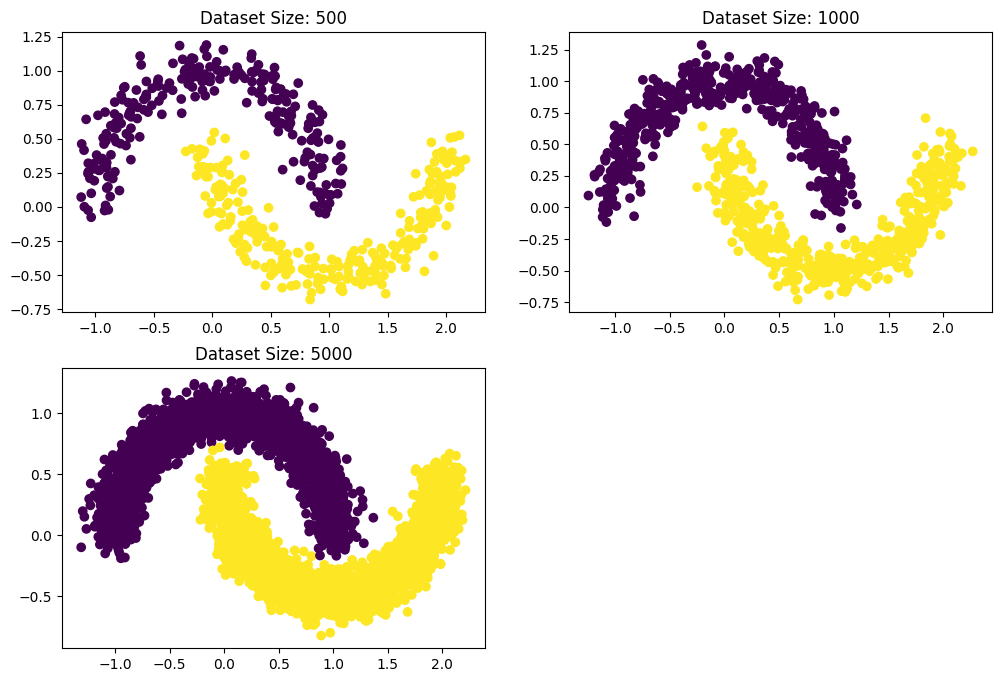

In [7]:
dataset_sizes = [ 500, 1000, 5000]

# Generate datasets of varying sizes
train_datasets = {}
val_datasets = {}
datasets = {}

for size in dataset_sizes:
    X, y = make_moons(n_samples=size, noise=0.1)
    datasets[size] = {'X': X, 'y': y}
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_datasets[size] = {'X': torch.FloatTensor(X_train), 'y': y_train}
    val_datasets[size] = {'X': torch.FloatTensor(X_test), 'y': y_test}

# Visualize the training datasets
plt.figure(figsize=(12, 8))

for i, size in enumerate(dataset_sizes, 1):
    plt.subplot(2, 2, i)
    plt.scatter(datasets[size]['X'][:, 0], datasets[size]['X'][:, 1], c=datasets[size]['y'])
    plt.title(f'Dataset Size: {size}')

plt.show()


In [8]:
### creating the dataloader for the make moons dataset
from torch.utils.data import DataLoader, TensorDataset

In [9]:
#train_datasets[dataset_size]['X']

In [10]:
###
input_size=2
hidden_size=256
blocks=2
print_after=1



#### data for the two-moons model
dataset_size=500
batch_size=32
data_considered=train_datasets[dataset_size]['X']
print("shape of the data_considered"); print(data_considered.shape)
train_loader = torch.utils.data.DataLoader(data_considered, batch_size=32, shuffle=True)
####

### instantiate the model
model= RealNVP(input_size=2, hidden_size= hidden_size, blocks=blocks)

## train the model
train_losses= train_inn(model, train_loader, num_epochs=20, lr=0.001, print_after=1)

shape of the data_considered
torch.Size([350, 2])
Epoch 1/20, Training Loss: -1.1687478260560469
Epoch 2/20, Training Loss: -18.738138588992033
Epoch 3/20, Training Loss: -93.81362290815873
Epoch 4/20, Training Loss: -398.4428919011896
Epoch 5/20, Training Loss: -1243.9382934570312
Epoch 6/20, Training Loss: -3293.3470348011365
Epoch 7/20, Training Loss: -7578.513760653409
Epoch 8/20, Training Loss: -15223.379350142046
Epoch 9/20, Training Loss: -27765.492542613636
Epoch 10/20, Training Loss: -47174.87073863636
Epoch 11/20, Training Loss: -75542.82315340909
Epoch 12/20, Training Loss: -114164.47301136363
Epoch 13/20, Training Loss: -167666.41051136365
Epoch 14/20, Training Loss: -237709.37926136365
Epoch 15/20, Training Loss: -327283.6022727273
Epoch 16/20, Training Loss: -431083.3096590909
Epoch 17/20, Training Loss: -567941.8551136364
Epoch 18/20, Training Loss: -751914.5965909091
Epoch 19/20, Training Loss: -881020.2102272727
Epoch 20/20, Training Loss: -1178048.8068181819
Training 

In [ ]:
# import torch


# # Example data
# data_size = 500
# input_size = 2
# hidden_size = 256
# blocks = 3
# print_after = 10

# # Create a dummy dataset
# X = torch.randn(data_size, input_size)
# print("shape of the dataset is:"); print(X.shape)
# print("X is :"); print(X)

# # Create a DataLoader for the dataset
# train_dataset = TensorDataset(X)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# # Initialize the RealNVP model
# model2 = RealNVP(input_size, hidden_size, blocks)

# # Train the model
# train_losses = train_inn(model2, train_loader, num_epochs=1, lr=0.001, print_after=1)

# ## Print the final training and validation losses
# #print(f"Final Training Loss: {train_losses[-1]}, Final Validation Loss: {val_losses[-1]}")
